In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from NegativeClassOptimization import config
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from NegativeClassOptimization.preprocessing import *
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from scipy.stats import pearsonr

In [3]:
task_2_folder = {'vs 9':'1v9', 'vs Non-binder':'high_vs_95low', 'vs Weak': 'high_vs_looser', 'vs 1':'1v1'}

In [4]:
tasks = ['vs 9', 'vs Non-binder', 'vs Weak'] # also add "vs 1"

In [5]:
ag_order = [
        "1FBI",
        "3VRL",
        "2YPV",
        "5E94",
        "1WEJ",
        "1OB1",
        "1NSN",
        "1H0D",
        "3RAJ",
        "1ADQ",
    ]

In [6]:
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}

In [7]:
def get_absolut_train_test_energy(task, ags_list, split):
    if task == 'vs 1':
        test_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{task_2_folder[task]}/seed_0/split_{split}/{ags_list[0]}__vs__{ags_list[1]}/*_test_dataset.tsv')[0]
        train_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{task_2_folder[task]}/seed_0/split_{split}/{ags_list[0]}__vs__{ags_list[1]}/*_train_dataset.tsv')[0]
    else:
        test_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{task_2_folder[task]}/seed_0/split_{split}/{ags_list[0]}*/*_test_dataset.tsv')[0]
        train_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{task_2_folder[task]}/seed_0/split_{split}/{ags_list[0]}*/*_train_dataset.tsv')[0]

    df_test =  pd.read_csv(test_path, sep='\t').drop(['binds_a_pos_ag', 'Slide_onehot', 'X'], axis=1)
    df_train =  pd.read_csv(train_path, sep='\t').drop(['binds_a_pos_ag', 'Slide_onehot', 'X'], axis=1)

    #combine with energy data
    path_pos = glob.glob(f'../data/full_data/divided2classes/{ags_list[0]}*/{ags_list[0]}_[A-Z]_MascotteSlices.txt')[0]
    pos_eng = pd.read_csv(path_pos, sep='\t', header=1)[['ID_slide_Variant', 'Slide', 'Energy']]

    if task == 'vs 9':
        paths_neg = glob.glob(f'../data/full_data/divided2classes/[^{ag}]*/*_MascotteSlices.txt')
        neg_engs = []
        for path in paths_neg:
            neg_eng = pd.read_csv(path,  sep='\t', header=1)[['ID_slide_Variant', 'Slide', 'Energy']]
            neg_engs.append(neg_eng)
        neg_engs = pd.concat(neg_engs)
        eng_df = pd.concat([pos_eng, neg_engs])
        
    elif task == 'vs 1':
        path_neg = glob.glob(f'../data/full_data/divided2classes/{ags_list[1]}*/{ags_list[1]}_[A-Z]_MascotteSlices.txt')[0]
        neg_eng = pd.read_csv(path_neg,  sep='\t', header=1)[['ID_slide_Variant', 'Slide', 'Energy']]
        eng_df = pd.concat([pos_eng, neg_eng])

    else:
        path_neg = glob.glob(f'../data/full_data/divided2classes/{ag}*/{ag}_[A-Z]_500kNonMascotte.txt')[0]
        path_loose = glob.glob(f'../data/full_data/divided2classes/{ag}*/{ag}_[A-Z]_LooserExclusiveSlices.txt')[0]
        neg_eng = pd.read_csv(path_neg,  sep='\t', header=1)[['ID_slide_Variant', 'Slide', 'Energy']]
        wk_eng = pd.read_csv(path_loose,  sep='\t', header=1)[['ID_slide_Variant', 'Slide', 'Energy']]
        eng_df = pd.concat([pos_eng, neg_eng, wk_eng])
    df_test = df_test.merge(eng_df,on='Slide', how='left').drop_duplicates(subset=['Slide', 'Energy'])
    df_train = df_train.merge(eng_df,on='Slide', how='left').drop_duplicates(subset=['Slide', 'Energy'])
    
    return df_train, df_test

In [8]:
def find_one_char_diff_pairs(df_train, df_test):
    placeholder = '*'
    seen = {}
    pairs = []

    # Process the first set: store modified sequences with their identifiers
    for train_sequence in df_train['Slide']:
        for i in range(len(train_sequence)):
            modified = train_sequence[:i] + placeholder + train_sequence[i+1:]
            if modified in seen:
                seen[modified].append(train_sequence)
            else:
                seen[modified] = [train_sequence]

    # Process the second set and look for matches in the dictionary
    for test_sequence in df_test['Slide']:
        for i in range(len(test_sequence)):
            modified = test_sequence[:i] + placeholder + test_sequence[i+1:]
            if modified in seen:
                for train_seq in seen[modified]:
                    pairs.append([train_seq, test_sequence])

    return pairs


In [9]:
def get_leak_info(df_train,df_test, pairs):
    train_lookup_dict = df_train.set_index('Slide').to_dict(orient='index')
    test_lookup_dict = df_test.set_index('Slide').to_dict(orient='index')
    leak_info = []
    concordance_dict = {
    '11':'++',
    '00':'--',
    '10':'+-',
    '01':'-+'}
    for train_slide, test_slide in pairs: #mixed up
        train_label = train_lookup_dict[train_slide]['y']
        train_eng = train_lookup_dict[train_slide]['Energy']

        test_label = test_lookup_dict[test_slide]['y']
        test_eng = test_lookup_dict[test_slide]['Energy']
        label_concordance = str(train_label) + str(test_label)
        label_concordance = concordance_dict[label_concordance]
        eng_diff = train_eng - test_eng
        leak_info.append([train_slide, test_slide, label_concordance, eng_diff])
    leak_df = pd.DataFrame(leak_info, columns=['train_Slide', 'test_Slide', 'label_concordance', 'Energy_diff'])
    return leak_df

In [10]:
EXECUTE = False
if EXECUTE:
        task = 'vs 1'
        split = 42 
        for ag_pos in config.ANTIGENS:
                neg_ags =set(config.ANTIGENS) - {ag_pos}
                for ag_neg in neg_ags:
                        df_train, df_test = get_absolut_train_test_energy(task, [ag_pos, ag_neg], split)
                        pairs = find_one_char_diff_pairs(df_train, df_test)
                        leak_df = get_leak_info(df_train,df_test, pairs)
                        leak_df.to_csv(f'./data-leak-res/{ag_pos}__{ag_neg}__{task}__{split}.csv')

In [11]:
EXECUTE = False
if EXECUTE:
    for ag in config.ANTIGENS:
        for task in tasks:
            for split in [0,1,2,3,4,42]:
                try:
                    df_train, df_test = get_absolut_train_test_energy(task, [ag], split)
                    pairs = find_one_char_diff_pairs(df_train, df_test)
                    leak_df = get_leak_info(df_train,df_test, pairs)
                    leak_df.to_csv(f'./data-leak-res/{ag}__{task}__{split}.csv')
                except IndexError:
                    print('No dataset with given characteristics')

In [12]:
def combine_ag_leaks(task, split=42):
    """I can try to do it over all splits and integrate error  wiskers to the barplots. Otherwise why I calculated all them?"""
    ag_leaks = []
    #not optimal but what can I do...
    if task == 'vs 1':
        for ag_pos in config.ANTIGENS:
            neg_ags =set(config.ANTIGENS) - {ag_pos}
            for ag_neg in neg_ags:
                df = pd.read_csv(f'./data-leak-res/{ag_pos}__{ag_neg}__{task}__{split}.csv')
                df['pos_ag'] = ag_pos
                df['neg_ag'] = ag_neg
                ag_leaks.append(df)
        ag_leaks_df = pd.concat(ag_leaks)  
    else:
        for ag in config.ANTIGENS:
            df = pd.read_csv(f'./data-leak-res/{ag}__{task}__{split}.csv')
            df['Antigen'] = ag
            ag_leaks.append(df)
        ag_leaks_df = pd.concat(ag_leaks)  
    return ag_leaks_df

In [13]:
def label_concordance_count(ag_leaks_df, task,  normalize):
    """I can try to do it over all splits and integrate error  wiskers to the barplots. Otherwise why I calculated all them?"""
    if normalize:
        #grouped_counts = ag_leaks_df.groupby(['Antigen','label_concordance']).size().unstack(level=-1, fill_value=0)
        if task == 'vs 1':
            grouped_counts = ag_leaks_df.groupby(['pos_ag', 'neg_ag','test_Slide','label_concordance']).size().unstack(level=-1, fill_value=0)
        else:
            grouped_counts = ag_leaks_df.groupby(['Antigen','test_Slide','label_concordance']).size().unstack(level=-1, fill_value=0)
        unique_test_slide_count = 10000 if task != 'vs 9' else 9995

        #n_seq_grouped_counts =ag_leaks_df.groupby('Antigen').count()['test_Slide']
        
        #label_concordance_abundance = grouped_counts.divide(n_seq_grouped_counts, axis=0).multiply(leak_raio, axis=0)
        row_sum = grouped_counts.sum(axis=1)
        label_concordance_abundance = grouped_counts.div(row_sum, axis=0)
        #leak_raio = ag_leaks_df.groupby('Antigen').nunique()['test_Slide']/unique_test_slide_count
        #leak_raio = leak_raio.reindex(label_concordance_abundance.index)
        #label_concordance_abundance = label_concordance_abundance.mul(leak_raio, axis=0)
        if task == 'vs 1':
            label_concordance_abundance = label_concordance_abundance.sum(axis=0, level=['pos_ag', 'neg_ag'])/unique_test_slide_count
        else:
            label_concordance_abundance = label_concordance_abundance.sum(axis=0, level='Antigen')/unique_test_slide_count
        return label_concordance_abundance
    else:
        if task == 'vs 1':
            conc_count = ag_leaks_df.groupby(['pos_ag', 'neg_ag','label_concordance']).size().reset_index().pivot(columns='label_concordance', index=['pos_ag', 'neg_ag'], values=0)
        else:
            conc_count = ag_leaks_df.groupby(['Antigen','label_concordance']).size().reset_index().pivot(columns='label_concordance', index='Antigen', values=0)
        return conc_count

In [14]:
"""def label_concordance_count(ag_leaks_df, task,  normalize):
    #I can try to do it over all splits and integrate error  wiskers to the barplots. Otherwise why I calculated all them?
    if normalize:
        #grouped_counts = ag_leaks_df.groupby(['Antigen','label_concordance']).size().unstack(level=-1, fill_value=0)
        grouped_counts = ag_leaks_df.groupby(['Antigen','test_Slide','label_concordance']).size().unstack(level=-1, fill_value=0)
        unique_test_slide_count = 10000 if task != 'vs 9' else 9995

        #n_seq_grouped_counts =ag_leaks_df.groupby('Antigen').count()['test_Slide']
        
        #label_concordance_abundance = grouped_counts.divide(n_seq_grouped_counts, axis=0).multiply(leak_raio, axis=0)
        row_sum = grouped_counts.sum(axis=1)
        label_concordance_abundance = grouped_counts.div(row_sum, axis=0)
        #leak_raio = ag_leaks_df.groupby('Antigen').nunique()['test_Slide']/unique_test_slide_count
        #leak_raio = leak_raio.reindex(label_concordance_abundance.index)
        #label_concordance_abundance = label_concordance_abundance.mul(leak_raio, axis=0)
        label_concordance_abundance = label_concordance_abundance.sum(axis=0, level='Antigen')/unique_test_slide_count
        return label_concordance_abundance
    else:
        conc_count = ag_leaks_df.groupby(['Antigen', 'label_concordance']).size().reset_index().pivot(columns='label_concordance', index='Antigen', values=0)
        return conc_count"""

"def label_concordance_count(ag_leaks_df, task,  normalize):\n    #I can try to do it over all splits and integrate error  wiskers to the barplots. Otherwise why I calculated all them?\n    if normalize:\n        #grouped_counts = ag_leaks_df.groupby(['Antigen','label_concordance']).size().unstack(level=-1, fill_value=0)\n        grouped_counts = ag_leaks_df.groupby(['Antigen','test_Slide','label_concordance']).size().unstack(level=-1, fill_value=0)\n        unique_test_slide_count = 10000 if task != 'vs 9' else 9995\n\n        #n_seq_grouped_counts =ag_leaks_df.groupby('Antigen').count()['test_Slide']\n        \n        #label_concordance_abundance = grouped_counts.divide(n_seq_grouped_counts, axis=0).multiply(leak_raio, axis=0)\n        row_sum = grouped_counts.sum(axis=1)\n        label_concordance_abundance = grouped_counts.div(row_sum, axis=0)\n        #leak_raio = ag_leaks_df.groupby('Antigen').nunique()['test_Slide']/unique_test_slide_count\n        #leak_raio = leak_raio.reinde

In [15]:
weak_ags_leaks_df = combine_ag_leaks('vs Weak')
nb_ags_leaks_df = combine_ag_leaks('vs Non-binder')
vs9_ags_leaks_df = combine_ag_leaks('vs 9')
vs1_ags_leaks_df = combine_ag_leaks('vs 1')

In [16]:
weak_conc_count = label_concordance_count(weak_ags_leaks_df, 'vs Weak', True)
nb_conc_count = label_concordance_count(nb_ags_leaks_df, 'vs Non-binder', True)
vs9_conc_count = label_concordance_count(vs9_ags_leaks_df, 'vs 9', True)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_51032/3250865589.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  label_concordance_abundance = label_concordance_abundance.sum(axis=0, level='Antigen')/unique_test_slide_count
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_51032/3250865589.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  label_concordance_abundance = label_concordance_abundance.sum(axis=0, level='Antigen')/unique_test_slide_count
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_51032/3250865589.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in 

In [17]:
v1_conc_count = label_concordance_count(vs1_ags_leaks_df, 'vs 1', True)
v1_conc_count = v1_conc_count.reset_index()

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_51032/3250865589.py:20: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  label_concordance_abundance = label_concordance_abundance.sum(axis=0, level=['pos_ag', 'neg_ag'])/unique_test_slide_count


In [18]:
v1_conc_count['conc_count'] = v1_conc_count['++'] + v1_conc_count['--']
v1_conc_count['discor_count'] = v1_conc_count['+-'] + v1_conc_count['-+']

In [19]:
v1_conc_count['ag_pairs'] = v1_conc_count.apply(lambda row: '_'.join(sorted([row['pos_ag'], row['neg_ag']])), axis=1)

In [20]:
v1_conc_count_reduced = v1_conc_count.drop_duplicates(subset='ag_pairs')[['pos_ag', 'neg_ag', 'conc_count', 'discor_count']]

In [21]:
v1_leak_conc_heatmap = v1_conc_count.pivot(index='pos_ag', columns='neg_ag', values='conc_count').loc[ag_order][ag_order]
v1_leak_discor_heatmap = v1_conc_count.pivot(index='pos_ag', columns='neg_ag', values='discor_count').loc[ag_order][ag_order]

In [22]:
v1_conc_count_reduced[['conc_count', 'discor_count']].apply(sum, axis=1).min()

0.36860000000000004

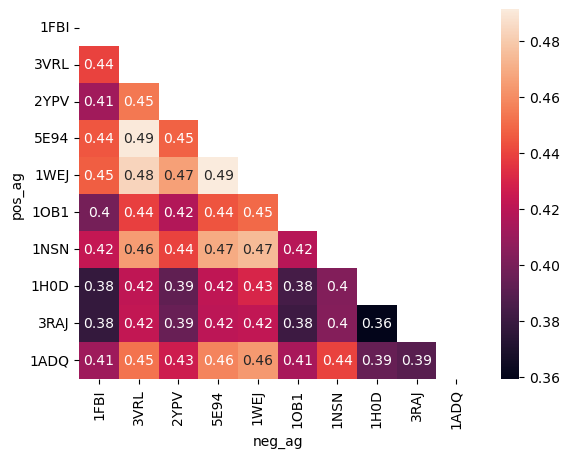

In [23]:
plt.rcParams['svg.fonttype'] = 'none'
mask = np.triu(v1_leak_conc_heatmap)
sns.heatmap(v1_leak_conc_heatmap, annot=True, mask=mask)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig('./figures/vs1_conc_leak.svg')

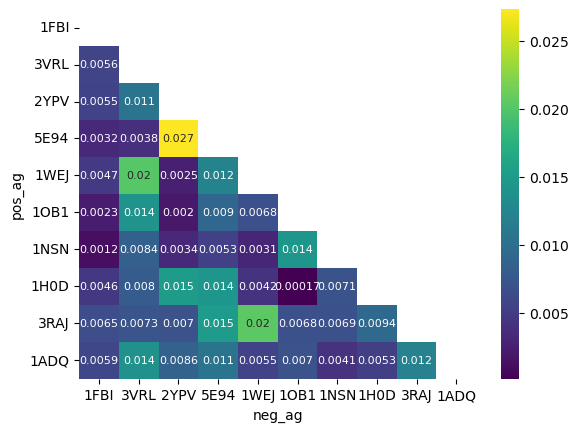

In [24]:
plt.rcParams['svg.fonttype'] = 'none'
mask = np.triu(v1_leak_discor_heatmap)
sns.heatmap(v1_leak_discor_heatmap, annot=True, annot_kws={"fontsize":8}, mask=mask, cmap='viridis') #these are totsl numbers
plt.yticks(rotation=0)
plt.savefig('./figures/vs1_discor_leak.svg')

In [25]:
col_order = ['++', '--', '+-', '-+']

In [26]:
def put_numbers_to_barplt(count_df):
    for i, ag in enumerate(ag_order):
        base = 0
        for color in col_order:
            y = count_df.loc[ag][color].round(2)
            plt.text(x=i-0.2, y=y/2+base, s=y, size="small")
            base += y

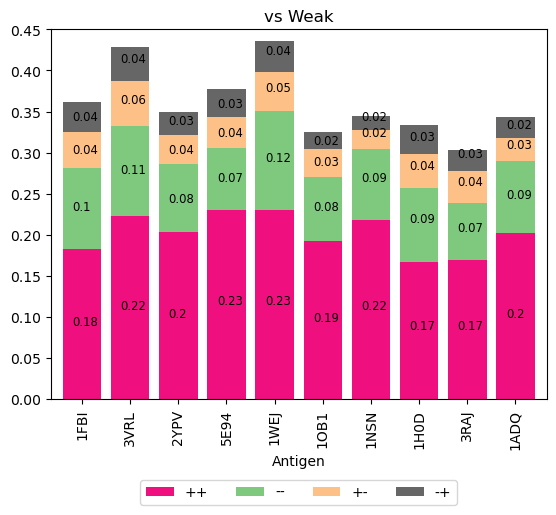

In [27]:
plt.rcParams['svg.fonttype'] = 'none'
#sns.set_style("white")
#sns.set_style('ticks')

weak_conc_count[col_order].loc[ag_order].plot(kind='bar', stacked=True, color=["#F00F7F", "#7FC97F", "#FDC086","#666666"], ylim=(0,0.45), width=0.8)
plt.title('vs Weak')
#hue_order=['++', '--', '+-', '-+'], order=ag_order, palette={"++": "#F00F7F", "--": "#7FC97F","+-": "#FDC086","-+":"#666666"}
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=5)
put_numbers_to_barplt(weak_conc_count)
plt.savefig('./figures/leak_90%_weak_recalc.svg')

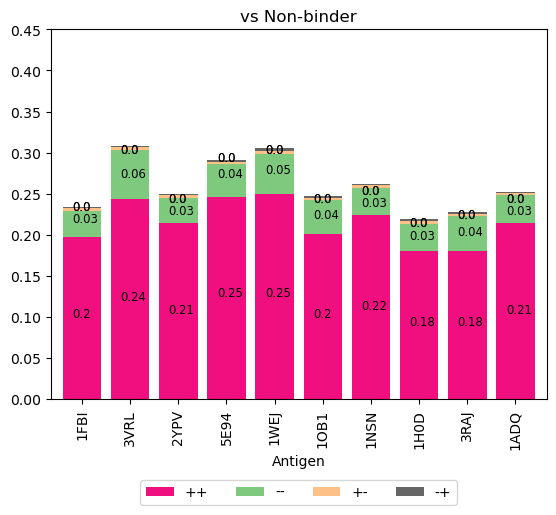

In [28]:
plt.rcParams['svg.fonttype'] = 'none'
#sns.set_style("white")
#sns.set_style('ticks')

nb_conc_count[col_order].loc[ag_order].plot(kind='bar', stacked=True, color=["#F00F7F", "#7FC97F", "#FDC086","#666666"], ylim=(0,0.45), width=0.8)
plt.title('vs Non-binder')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=5)
put_numbers_to_barplt(nb_conc_count)
plt.savefig('./figures/leak_90%_nb_recalc.svg')

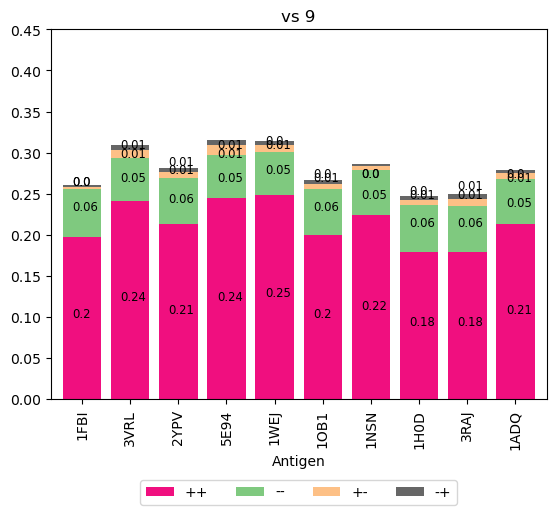

In [29]:
plt.rcParams['svg.fonttype'] = 'none'
#sns.set_style("white")
#sns.set_style('ticks')

vs9_conc_count[col_order].loc[ag_order].plot(kind='bar', stacked=True, color=["#F00F7F", "#7FC97F", "#FDC086","#666666"], ylim=(0,0.45), width=0.8)
plt.title('vs 9')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=5)
put_numbers_to_barplt(vs9_conc_count)
plt.savefig('./figures/leak_90%_vs9_recalc.svg')


In [30]:
weak_ags_leaks_df['Energy_diff_abs'] = weak_ags_leaks_df['Energy_diff'].abs()
nb_ags_leaks_df['Energy_diff_abs'] = nb_ags_leaks_df['Energy_diff'].abs()
vs9_ags_leaks_df['Energy_diff_abs'] = vs9_ags_leaks_df['Energy_diff'].abs()

In [31]:
def plot_meadian_for_energy_diff(df, hue_order):
    median_values = df.groupby(['Antigen', 'label_concordance']).median().reset_index()
    n_hues = len(hue_order) # Number of hues
    width_per_group = 1
    for i, row in median_values.iterrows():
        antigen = row['Antigen']
        label_concordance = row['label_concordance']
        median_value = row['Energy_diff_abs']

        if label_concordance in hue_order:

            antigen_index = ag_order.index(antigen)
            base_x_position = antigen_index * width_per_group

            # Calculate the offset for the current hue within the group
            hue_index = hue_order.index(label_concordance)
            hue_offset = (hue_index - (n_hues - 1) / 2) * (width_per_group / n_hues)

            # Final x-position
            x_position = base_x_position + hue_offset
            y_position = -0.4

            # Place the text
            plt.text(x_position, y_position, f'{median_value:.2f}', ha='center', va='top', rotation=90)

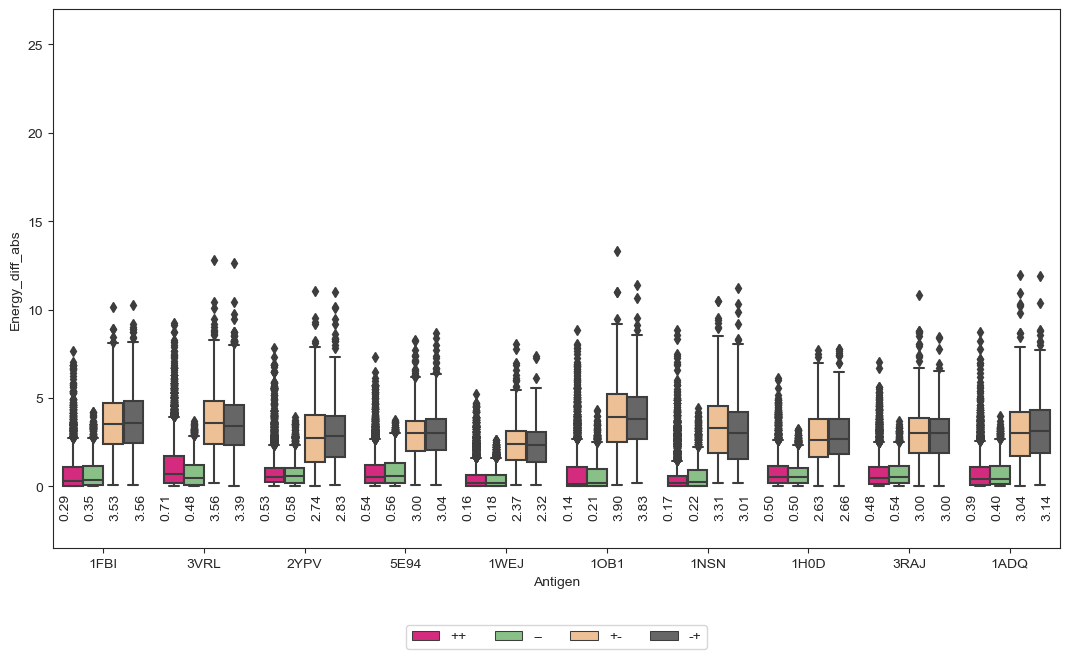

In [32]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')

plt.figure(figsize=(13, 7))
plt.ylim([-3.5,27])
hue_order=['++', '--', '+-', '-+']

sns.boxplot(weak_ags_leaks_df, x='Antigen', y='Energy_diff_abs', hue='label_concordance', showfliers=True,\
            hue_order=hue_order, order=ag_order, palette={"++": "#F00F7F", "--": "#7FC97F","+-": "#FDC086","-+":"#666666"})

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5)
plot_meadian_for_energy_diff(weak_ags_leaks_df, hue_order)
plt.savefig('./figures/leak_energy_weak_recalc_font.svg', transparent=True)


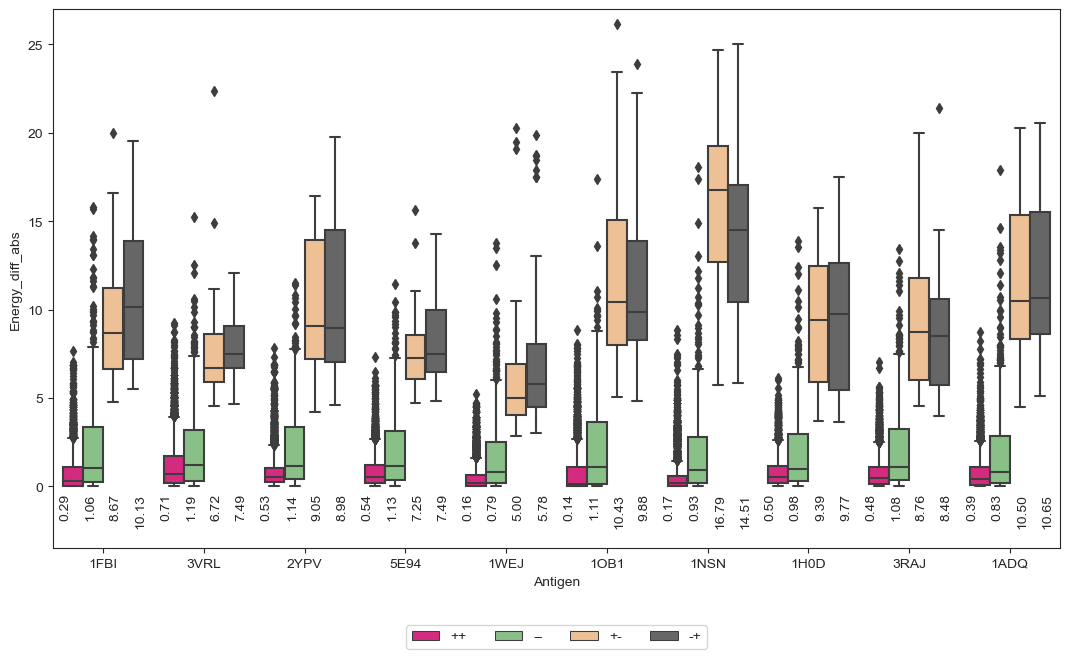

In [33]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')

plt.figure(figsize=(13, 7))
plt.ylim([-3.5,27])
hue_order=['++', '--', '+-', '-+']

sns.boxplot(nb_ags_leaks_df, x='Antigen', y='Energy_diff_abs', hue='label_concordance', showfliers=True,\
            hue_order=hue_order, order=ag_order, palette={"++": "#F00F7F", "--": "#7FC97F","+-": "#FDC086","-+":"#666666"})

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5)

plot_meadian_for_energy_diff(nb_ags_leaks_df, hue_order)

plt.savefig('./figures/leak_energy_nb_recalc_bigger.svg')


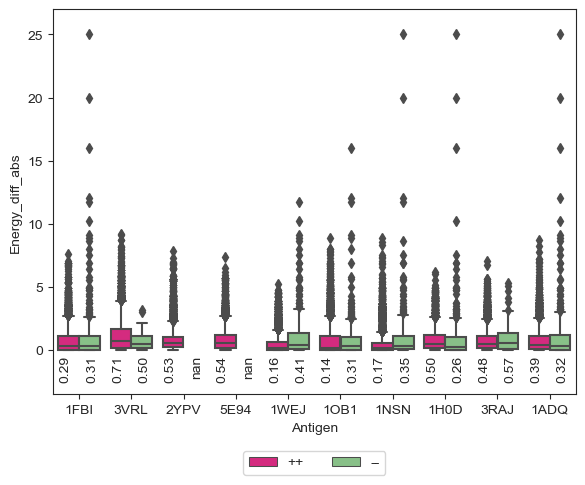

In [34]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')

plt.figure(figsize=(6.75, 5))
plt.ylim([-3.5,27])
hue_order=['++', '--']

sns.boxplot(vs9_ags_leaks_df, x='Antigen', y='Energy_diff_abs', showfliers=True,\
            hue='label_concordance', hue_order=hue_order, order=ag_order, palette={"++": "#F00F7F", "--": "#7FC97F"})

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5)
plot_meadian_for_energy_diff(vs9_ags_leaks_df, hue_order)

plt.savefig('./figures/leak_energy_vs9_recalc.svg')

In [35]:
##How leak correlates with performance?
perf_df = pd.read_csv('../data/openset_performance.tsv', sep='\t')
perf_df[['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id']] = perf_df.task_1.str.split('__', expand=True)
perf_df[['test_task', 'test_ag', 'test_neg', 'test_seed_id', 'test_split_id']] = perf_df.task_2.str.split('__', expand=True)
perf_df.drop(['task_1', 'task_2'], inplace=True, axis=1)
task_rename = {'ONE_VS_NINE': 'vs 9', 'HIGH_VS_95LOW': 'vs Non-binder', 'HIGH_VS_LOOSER': 'vs Weak'}
perf_df['train_task'] = perf_df['train_task'].apply(lambda x: task_rename[x])
perf_df['test_task'] = perf_df['test_task'].apply(lambda x: task_rename[x])

In [36]:
perf_closed = perf_df[perf_df['train_task'] == perf_df['test_task']]

In [37]:
weak_ags_leaks_df['Energy_diff_abs'] = weak_ags_leaks_df['Energy_diff'].abs()
nb_ags_leaks_df['Energy_diff_abs'] = nb_ags_leaks_df['Energy_diff'].abs()
vs9_ags_leaks_df['Energy_diff_abs'] = vs9_ags_leaks_df['Energy_diff'].abs()

In [38]:
def leak_perf_corr(task, split, labels_to_keep, energy_cut=False):
    df_leak = combine_ag_leaks(task)
    if energy_cut:
        df_leak = df_leak[df_leak['Energy_diff'].abs() <= energy_cut]
    conc_count = label_concordance_count(df_leak, task, True)
    conc_count = conc_count[labels_to_keep].sum(axis=1).reset_index().rename(columns={0:'leak_ratio'})
    #getting performances
    task_selection = perf_closed['train_task'] == task
    seed_selection = perf_closed['test_seed_id'] == '0'
    split_selectio = perf_closed['test_split_id'] == str(split)
    perf_task = perf_closed[task_selection & seed_selection & split_selectio][['train_ag', 'acc']]
    perf_leak_df = perf_task.merge(conc_count, left_on='train_ag', right_on='Antigen')
    return perf_leak_df



In [39]:
def leak_open_perf_corr(train_task, test_task, split, labels_to_keep,  energy_cut=False):
    df_leak = combine_ag_leaks(train_task)
    if energy_cut:
        df_leak = df_leak[df_leak['Energy_diff'].abs() <= energy_cut]
    conc_count = label_concordance_count(df_leak, train_task, True)
    conc_count = conc_count[labels_to_keep].sum(axis=1).reset_index().rename(columns={0:'leak_ratio'})
    #getting performances
    task_selection = (perf_df['train_task'] == train_task) & (perf_df['test_task'] == test_task)
    seed_selection = perf_df['test_seed_id'] == '0'
    split_selectio = perf_df['test_split_id'] == str(split)
    perf_task = perf_df[task_selection & seed_selection & split_selectio][['train_ag', 'acc']]
    perf_leak_df = perf_task.merge(conc_count, left_on='train_ag', right_on='Antigen')
    return perf_leak_df



In [40]:
split =42
task = 'vs Non-binder'
perf_leak_nb = leak_perf_corr(task, split, ['++', '--'])

task = 'vs Weak'
perf_leak_wk = leak_perf_corr(task, split, ['++', '--'])

task = 'vs 9'
perf_leak_vs9 = leak_perf_corr(task, split, ['++', '--'])

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_51032/3250865589.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  label_concordance_abundance = label_concordance_abundance.sum(axis=0, level='Antigen')/unique_test_slide_count
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_51032/3250865589.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  label_concordance_abundance = label_concordance_abundance.sum(axis=0, level='Antigen')/unique_test_slide_count
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_51032/3250865589.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in 

In [41]:
def corr_to_plot(xs, ys):
    r, pval = pearsonr(xs, ys)
    x_plot = xs.mean()
    y_plot = ys.mean()
    return r, x_plot, y_plot, pval

In [42]:
seed = 0

In [43]:
df_1vs1_perf = pd.read_csv('../data/1vs1_perf.tsv', sep='\t', index_col=0)
df_1vs1_perf = df_1vs1_perf[(df_1vs1_perf['seed_id'] == seed) & (df_1vs1_perf['split_id'] == split)]
df_1vs1_perf = df_1vs1_perf.rename(columns={'train_ag': 'pos_ag','train_neg': 'neg_ag'})

In [44]:
perf_leak_vs1 = v1_conc_count = v1_conc_count.merge(df_1vs1_perf, on = ['pos_ag', 'neg_ag'])
perf_leak_vs1_wo_dupl = perf_leak_vs1.drop_duplicates('ag_pairs')

In [45]:
perf_leak_vs1_wo_dupl.shape

(45, 21)

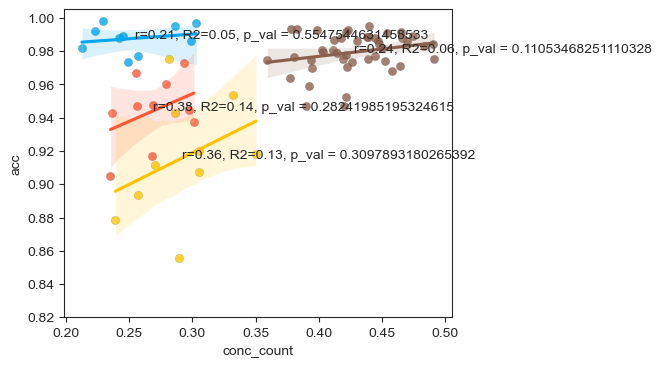

In [46]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(5,4))
sns.regplot(data=perf_leak_nb, x='leak_ratio', y='acc',ax=ax, color='#00A6ED', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1})
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_nb['leak_ratio'], perf_leak_nb['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)

sns.regplot(data=perf_leak_wk, x='leak_ratio', y='acc',ax=ax, color='#FFC300', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1})
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_wk['leak_ratio'], perf_leak_wk['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)

sns.regplot(data=perf_leak_vs9, x='leak_ratio', y='acc',ax=ax, color='#FF5733', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1})
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_vs9['leak_ratio'], perf_leak_vs9['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)

sns.regplot(data=perf_leak_vs1_wo_dupl, x='conc_count', y='acc', color='#8B5F4D', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1}, ax=ax)
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_vs1_wo_dupl['conc_count'], perf_leak_vs1_wo_dupl['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)
plt.yticks(np.arange(0.82, 1,0.02))

fig.savefig('./figures/leak_corr_recalc.svg')

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_51032/3250865589.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  label_concordance_abundance = label_concordance_abundance.sum(axis=0, level='Antigen')/unique_test_slide_count
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_51032/3250865589.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  label_concordance_abundance = label_concordance_abundance.sum(axis=0, level='Antigen')/unique_test_slide_count
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_51032/3250865589.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in 

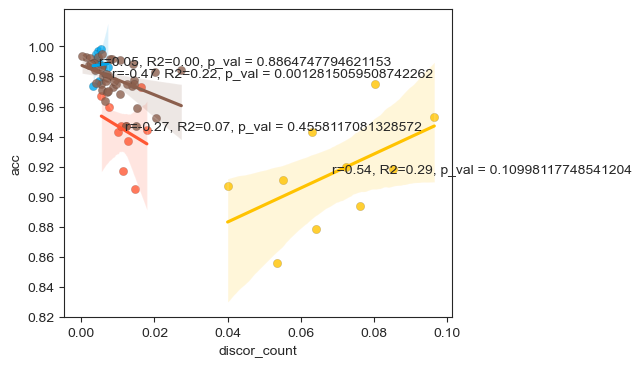

In [47]:
split =42
task = 'vs Non-binder'
perf_leak_nb_dis = leak_perf_corr(task, split, ['+-', '-+'])

task = 'vs Weak'
perf_leak_wk_dis = leak_perf_corr(task, split,['+-', '-+'])

task = 'vs 9'
perf_leak_vs9_dis = leak_perf_corr(task, split,['+-', '-+'])


plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(5,4))
sns.regplot(data=perf_leak_nb_dis, x='leak_ratio', y='acc',ax=ax, color='#00A6ED', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1})
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_nb_dis['leak_ratio'], perf_leak_nb_dis['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)

sns.regplot(data=perf_leak_wk_dis, x='leak_ratio', y='acc',ax=ax, color='#FFC300', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1})
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_wk_dis['leak_ratio'], perf_leak_wk_dis['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)

sns.regplot(data=perf_leak_vs9_dis, x='leak_ratio', y='acc',ax=ax, color='#FF5733', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1})
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_vs9_dis['leak_ratio'], perf_leak_vs9_dis['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)

sns.regplot(data=perf_leak_vs1_wo_dupl, x='discor_count', y='acc', color='#8B5F4D', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1}, ax=ax)
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_vs1_wo_dupl['discor_count'], perf_leak_vs1_wo_dupl['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)
plt.yticks(np.arange(0.82, 1,0.02))
fig.savefig('./figures/leak_corr_difflabes.svg')

In [48]:
split =42
task = 'vs Non-binder'
test_task = 'vs Weak'
ood_perf_leak_nb_weak = leak_open_perf_corr(task, test_task, split, ['++', '--'])
test_task = 'vs 9'
ood_perf_leak_nb_vs9 = leak_open_perf_corr(task, test_task, split, ['++', '--'])

task = 'vs Weak'
test_task = 'vs Non-binder'
ood_leak_wk_nb = leak_open_perf_corr(task, test_task, split, ['++', '--'])
test_task = 'vs 9'
ood_leak_wk_vs9 = leak_open_perf_corr(task, test_task, split, ['++', '--'])

task = 'vs 9'
test_task = 'vs Non-binder'
ood_leak_wk_vs9_nb = leak_open_perf_corr(task, test_task, split, ['++', '--'])
test_task = 'vs Weak'
ood_leak_wk_vs9_weak = leak_open_perf_corr(task, test_task, split, ['++', '--'])


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_51032/3250865589.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  label_concordance_abundance = label_concordance_abundance.sum(axis=0, level='Antigen')/unique_test_slide_count
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_51032/3250865589.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  label_concordance_abundance = label_concordance_abundance.sum(axis=0, level='Antigen')/unique_test_slide_count
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_51032/3250865589.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in 

In [49]:
ood_leak_wk_vs9

,train_ag,acc,Antigen,leak_ratio
0,3VRL,0.968284,3VRL,0.332369
1,1NSN,0.902951,1NSN,0.304900
2,3RAJ,0.857429,3RAJ,0.239186
3,5E94,0.931466,5E94,0.305103
4,1H0D,0.821311,1H0D,0.257018
5,1WEJ,0.903152,1WEJ,0.350374
6,1ADQ,0.842821,1ADQ,0.289648
7,1FBI,0.973887,1FBI,0.281406
8,2YPV,0.868134,2YPV,0.286105
9,1OB1,0.919460,1OB1,0.270172


In [50]:
def plot_ood_leak_correlation(perf_leak_df, train_task, test_task, ax):

    sns.regplot(data=perf_leak_df, x='leak_ratio', y='acc', color=cmap[test_task], scatter_kws={'edgecolor': 'black', 'linewidth': 0.1}, ax=ax)
    ax.set_title(f'Train task: {train_task}')
    r, x_plot, y_plot, pval = corr_to_plot(perf_leak_df['leak_ratio'], perf_leak_df['acc'])
    ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f},\n p_val = {pval}" , fontsize=10)

In [550]:
ood_perf_leak_nb_weak = leak_open_perf_corr(task, test_task, split, ['++', '--'])
test_task = 'vs 9'
ood_perf_leak_nb_vs9 = leak_open_perf_corr(task, test_task, split, ['++', '--'])

task = 'vs Weak'
test_task = 'vs Non-binder'
ood_leak_wk_nb = leak_open_perf_corr(task, test_task, split, ['++', '--'])
test_task = 'vs 9'
ood_leak_wk_vs9 = leak_open_perf_corr(task, test_task, split, ['++', '--'])

task = 'vs 9'
test_task = 'vs Non-binder'
ood_leak_vs9_nb = leak_open_perf_corr(task, test_task, split, ['++', '--'])
test_task = 'vs Weak'
ood_leak_vs9_weak = leak_open_perf_corr(task, test_task, split, ['++', '--'])

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_92235/3250865589.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  label_concordance_abundance = label_concordance_abundance.sum(axis=0, level='Antigen')/unique_test_slide_count
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_92235/3250865589.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  label_concordance_abundance = label_concordance_abundance.sum(axis=0, level='Antigen')/unique_test_slide_count
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_92235/3250865589.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in 

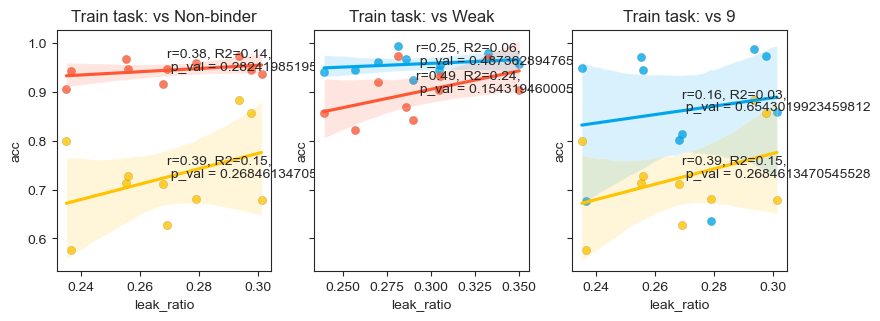

In [551]:
fig, ax = plt.subplots(1, 3, figsize=(3*3.14,3.14), sharey=True)

plot_ood_leak_correlation(ood_perf_leak_nb_weak, 'vs Non-binder', 'vs Weak', ax[0])
plot_ood_leak_correlation(ood_perf_leak_nb_vs9, 'vs Non-binder', 'vs 9', ax[0])

plot_ood_leak_correlation(ood_leak_wk_nb, 'vs Weak', 'vs Non-binder', ax[1])
plot_ood_leak_correlation(ood_leak_wk_vs9, 'vs Weak', 'vs 9', ax[1])

plot_ood_leak_correlation(ood_leak_vs9_nb, 'vs 9', 'vs Non-binder', ax[2])
plot_ood_leak_correlation(ood_leak_vs9_weak, 'vs 9', 'vs Weak', ax[2])


In [540]:
ood_perf_leak_nb_weak

,train_ag,acc,Antigen,leak_ratio
0,3VRL,0.7585,3VRL,0.303222
1,1NSN,0.7190,1NSN,0.257226
2,3RAJ,0.7056,3RAJ,0.223327
3,5E94,0.7142,5E94,0.286606
4,1H0D,0.7264,1H0D,0.212729
5,1WEJ,0.7690,1WEJ,0.298564
6,1ADQ,0.6844,1ADQ,0.248887
7,1FBI,0.7831,1FBI,0.229063
8,2YPV,0.7619,2YPV,0.245298
9,1OB1,0.7023,1OB1,0.242211


In [116]:
task_2TASK = {'vs 9': 'ONE_VS_NINE', 'vs Non-binder': 'HIGH_VS_95LOW', 'vs Weak': 'HIGH_VS_LOOSER'}
tasks_dict = {'ONE_VS_NINE': '1v9', 'HIGH_VS_95LOW': 'high_vs_95low', 'HIGH_VS_LOOSER': 'high_vs_looser'}
task_template = {'ONE_VS_NINE': '{ag}__vs__9', 'HIGH_VS_95LOW': '{ag}_high__vs__{ag}_95low', 'HIGH_VS_LOOSER': '{ag}_high__vs__{ag}_looser'}

In [238]:
def count_lesk_intersections(leaks_df):
    leak_seqs_intersection = leaks_df[['test_Slide', 'label_concordance']].groupby('test_Slide').nunique()
    leak_seqs_intersection_feq = leak_seqs_intersection['label_concordance'].value_counts().to_dict()
    return leak_seqs_intersection_feq


In [239]:
count_lesk_intersections(weak_ags_leaks_df)

{1: 29567, 2: 6185, 3: 48, 4: 6}

In [242]:
count_lesk_intersections(nb_ags_leaks_df)

{1: 25587, 2: 344}

In [241]:
count_lesk_intersections(vs9_ags_leaks_df)

{1: 20569, 2: 1279, 3: 157, 4: 76}

In [278]:
def model_mistakes_on_leak(task, seed, split, leaks_df_all_ag, consistent_leak=True):
    TASK = task_2TASK[task]
    error_rate_ag =dict()
    for ag in config.ANTIGENS:
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[TASK]}/seed_{seed}/split_{split}/{task_template[TASK].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device('cpu'))
        leaks_df = leaks_df_all_ag[leaks_df_all_ag['Antigen'] == ag]
        leaks_df_intersections = leaks_df[['test_Slide', 'label_concordance']].groupby('test_Slide').nunique().reset_index()
        if consistent_leak:
            leaks_df = leaks_df_intersections[leaks_df_intersections['label_concordance']==1].copy()
        else:
            leaks_df = leaks_df_intersections[leaks_df_intersections['label_concordance']!=1].copy()

        leaks_df['X'] = leaks_df.test_Slide.apply(onehot_encode)
        X = torch.tensor(np.array(leaks_df['X'].tolist()), dtype=torch.float32).to('cpu')
        y_pred = model(X, return_logits = False)
        y_pred = y_pred.cpu().detach().numpy().reshape(-1).round()
        leaks_df['y_pred'] = y_pred
        test_df_path = glob.glob(f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[TASK]}/seed_{seed}/split_{split}/{task_template[TASK].format(ag=ag)}/*_test_dataset.tsv")[0]
        test_df = pd.read_csv(test_df_path, sep='\t')
        leaks_df = leaks_df.merge(test_df[['Slide', 'y']], how='left', left_on = 'test_Slide', right_on = 'Slide' )
        error_rate = (leaks_df['y_pred'] !=  leaks_df['y']).sum()/len(leaks_df)
        error_rate_ag[ag] = error_rate
    return error_rate_ag


In [279]:
#weak_ags_leaks_df = combine_ag_leaks('vs Weak')
#nb_ags_leaks_df = combine_ag_leaks('vs Non-binder')
#vs9_ags_leaks_df = combine_ag_leaks('vs 9')

In [286]:
weak_certain = model_mistakes_on_leak('vs Weak', 0, 42, weak_ags_leaks_df)
weak_certain_amb = model_mistakes_on_leak('vs Weak', 0, 42, weak_ags_leaks_df, False)
pd.DataFrame.from_dict(exx, orient='index', columns=['error_rate_cons']).rename_axis('Antigen').reset_index()
pd.DataFrame.from_dict(exx, orient='index', columns=['error_rate_cons']).rename_axis('Antigen').reset_index()

In [298]:
def combine_error_rates(task, seed, split, leaks_df_all_ag):
    certain = model_mistakes_on_leak(task,  seed, split, leaks_df_all_ag)
    ambiguous = model_mistakes_on_leak(task,  seed, split, leaks_df_all_ag, False)
    certain = pd.DataFrame.from_dict(certain, orient='index', columns=['error_rate_cons']).rename_axis('Antigen').reset_index()
    ambiguous = pd.DataFrame.from_dict(ambiguous, orient='index', columns=['error_rate_amb']).rename_axis('Antigen').reset_index()
    error_rate_df =certain.merge(ambiguous, on='Antigen')
    return error_rate_df

In [299]:
weak_leak_error_rates = combine_error_rates('vs Weak', 0, 42, weak_ags_leaks_df)

In [302]:
nb_leak_error_rates = combine_error_rates('vs Non-binder', 0, 42, nb_ags_leaks_df)

In [303]:
vs9_leak_error_rates = combine_error_rates('vs 9', 0, 42, vs9_ags_leaks_df)

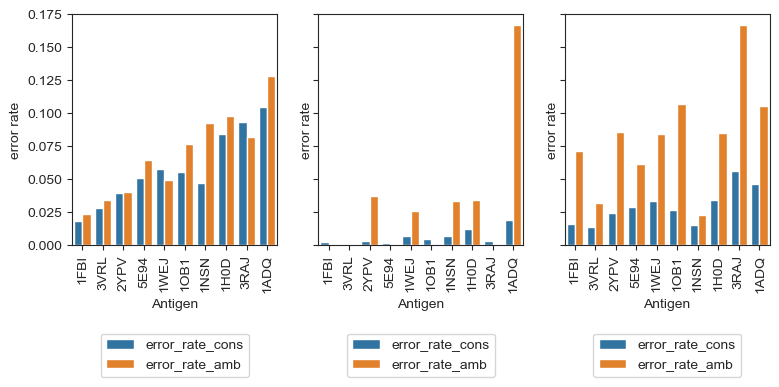

In [344]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey = True, figsize=(3*3,3))

weak_leak_error_rates_melt = weak_leak_error_rates.melt(value_vars=["error_rate_cons", "error_rate_amb"], value_name="error rate", id_vars=['Antigen'])
sns.barplot(weak_leak_error_rates_melt, x='Antigen', y='error rate', hue='variable', order=ag_order,ax=ax[0])
nb_leak_error_rates_melt = nb_leak_error_rates.melt(value_vars=["error_rate_cons", "error_rate_amb"], value_name="error rate", id_vars=['Antigen'])
sns.barplot(nb_leak_error_rates_melt, x='Antigen', y='error rate', hue='variable', order=ag_order,ax=ax[1])
vs9_leak_error_rates_melt = vs9_leak_error_rates.melt(value_vars=["error_rate_cons", "error_rate_amb"], value_name="error rate", id_vars=['Antigen'])
sns.barplot(vs9_leak_error_rates_melt, x='Antigen', y='error rate', hue='variable', order=ag_order, ax=ax[2])

for i in range(3):
    ax[i].set_xticklabels(ag_order,rotation=90)
    ax[i].legend(loc='lower center', bbox_to_anchor=(0.5, -0.6))
